In [3]:
import dataLoader as loader
import HDDMmodelMaker as ddm
import pandas as pd
import time
import matplotlib.pyplot as plt
import hddm
import random
import scipy.stats as st
import numpy as np
import seaborn as sns
import pymc as mc
import random 
import kabuki
from mpl_toolkits.mplot3d import Axes3D
import statsmodels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance
import kneed

SyntaxError: invalid syntax (kneed.py, line 14)

In [9]:
data = hddm.load_csv("data_actions.csv")

In [4]:
def actionChange(actions1, actions2, user1, user2, rt):
    if len(actions1) != len(actions2): return "Lenghts mismatch" #Raise exception
    rounds = len(actions1)
    prev1 = ""
    prev2 = ""
    switch_events = pd.DataFrame(columns=["type", "lag", "subject", "round", "rt"])
    lag = 0
    for r in range(0, rounds):
        if r ==0:
            prev1 = actions1[r]
            prev2 = actions2[r]
            lag += 1
            continue
        elif actions1[r] != prev1:
            switch_events = switch_events.append(
                {"context": prev2, "type": "%s%s" % (prev1, actions1[r]),
                 "lag": lag, "subject": user1, "round": r + 1, "rt": rt[r]}, ignore_index=True)
            lag = 0
        if actions2[r] == prev2:
            lag += 1
        else: lag = 1
        prev1 = actions1[r]
        prev2 = actions2[r]
    return switch_events

In [5]:
def actionCounts(actions, user):
    prosocial = ['CCC', 'CDC', '00C', 'DDC', 'DCC']
    proself = ['DDD', 'DCD', '00D', 'CCD', 'CDD']
    rating = 0
    act_df = {'user':user,'00D':0,'00C':0,'DCD':0,'CDC':0,'CCC':0,'CDD':0,'CCD':0,'DDC':0,'DCC':0,'DDD':0, 'type':"", 'score': 0}
    for a in actions:
        act_df[a] = act_df[a] + 1
        if a in prosocial:
            rating = rating + 1
        else: rating = rating - 1
    act_df["score"] = rating
    if rating >= 0: act_df["type"] = "Pro-social"
    else: act_df["type"] = "Pro-self"
    return act_df

In [6]:
switches = pd.DataFrame()
actions = pd.DataFrame()
for t in data.treatment.unique():
    t_df = data.loc[(data.treatment == t)]
    users = t_df.player.unique()
    switchesT = pd.DataFrame()
    actionsT = pd.DataFrame()
    for u in users:
        df = t_df.loc[t_df.player == u]
        df = df.sort_values(by = "round", ascending = True)
        opp = str(df.opponent.unique())
        acc1 = df.action_player.values
        acc2 = df.action_opponent.values
        rt = df["rt"].values
        switchesT = switchesT.append(actionChange(acc1, acc2, u, opp, rt))
        actionsT = actionsT.append(actionCounts(df.actions, u), ignore_index=True)
    switchesT["treatment"] = t
    actionsT["treatment"] = t
    switches = switches.append(switchesT, ignore_index = True)
    actions = actions.append(actionsT, ignore_index = True)

/Users/eladiomontero/opt/anaconda3/envs/decTimesEnv/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [7]:
## Adjusting weights for actions
actions["type_adj"] = ""
actions["score_adj"] = 0

for index, row in actions.iterrows():
    score = sum(row[0:10] * [3,-4,0,-4,4,0,0,-4,4,0])
    actions.iloc[index, 15] = score
    actions.iloc[index, 14] = "Pro-social" if score>=0 else "Pro-self"
actions

,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,score,type,user,treatment,type_adj,score_adj
0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,5.0,64.0,Pro-social,s3m7_usuario9,weak,Pro-self,-28.0
1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,5.0,78.0,Pro-social,s3m7_usuario18,weak,Pro-social,31.0
2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,Pro-social,s3m7_usuario7,weak,Pro-social,3.0
3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,Pro-social,s3m7_usuario10,weak,Pro-social,3.0
4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,98.0,Pro-social,s3m7_usuario13,weak,Pro-self,-1.0
5,1.0,0.0,98.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,100.0,Pro-social,s3m7_usuario5,weak,Pro-social,7.0
6,0.0,1.0,93.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,90.0,Pro-social,s3m7_usuario15,weak,Pro-social,0.0
7,1.0,0.0,93.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,90.0,Pro-social,s3m7_usuario16,weak,Pro-social,3.0
8,0.0,1.0,86.0,2.0,1.0,1.0,3.0,3.0,1.0,2.0,82.0,Pro-social,s3m7_usuario12,weak,Pro-self,-16.0
9,1.0,0.0,88.0,0.0,3.0,3.0,1.0,1.0,2.0,1.0,90.0,Pro-social,s3m7_usuario6,weak,Pro-social,19.0


In [4]:
data_svo = pd.merge(data, actions[["type", "user"]], left_on = "player", right_on = "user")
data_svo.opponent = data_svo['opponent'].str.strip("['']")

NameError: name 'actions' is not defined

In [5]:
data_svo

NameError: name 'data_svo' is not defined

# weak

In [10]:
actions = pd.read_csv("actions.csv")
weak = data[data.treatment == "weak"]
params_weak = pd.read_csv("params_weak.csv")

In [12]:
## trying a model per subject, with the whole dataset, then partitioning afterwards

params_weak = actions.loc[actions.treatment == "weak", ["user", "type", "score", "type_adj", "score_adj"]]
params_weak["a"] = 0
params_weak["v"] = 0
params_weak["t"] = 0
params_weak["z"] = 0
params_weak

modeler = ddm.HDDMmodelMaker()
for s in weak.player.unique():
    model_soc_s3 = modeler.fit_model(weak.loc[(weak["player"] == s)], 5000, 200)
    params_weak.loc[params_weak.user == s, ["a","v","t","z"]] = model_soc_s3.gen_stats()["mean"].values
    

 [-----------------100%-----------------] 5000 of 5000 complete in 5.1 sec

In [18]:
params_weak["y"] = 0
params_weak["y_adj"] = 0
params_weak.loc[params_weak["type"] == "Pro-social", ["y"]] = 1
params_weak.loc[params_weak["type"] == "Pro-self", ["y"]] = 0
params_weak.loc[params_weak["type_adj"] == "Pro-social", ["y_adj"]] = 1
params_weak.loc[params_weak["type_adj"] == "Pro-self", ["y_adj"]] = 0
weak_df = params_weak[["a","v", "t", "z", "y_adj"]]
weak_df

,a,v,t,z,y_adj
0,3.255287,0.104549,0.349740,0.761625,0
1,2.709906,0.175382,0.377830,0.830882,1
2,2.047376,2.015130,0.354075,0.725827,1
3,4.169979,0.461699,0.346234,0.885307,1
4,2.965683,0.841667,0.380724,0.775296,1
5,2.666073,1.158333,0.359542,0.738211,1
6,3.752886,0.534211,0.146685,0.711207,1
7,2.326765,0.926423,0.302067,0.701246,1
8,4.010591,0.105384,0.374135,0.860828,0
9,2.910864,0.446095,0.263144,0.824835,1


In [25]:
from sklearn.model_selection import train_test_split
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(weak_df[["a","v", "t", "z"]], weak_df[["y_adj"]], test_size=0.3)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape


(12, 4) (12, 1)
(6, 4) (6, 1)


In [27]:
## Test with logistic regression
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
model = LogisticRegression()

In [28]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 6-fold cross validation
scores = cross_val_score(model, weak_df[["a","v", "t", "z"]], weak_df[["y_adj"]], cv=10)
print ("Cross-validated scores:", scores)

('Cross-validated scores:', array([0.66666667, 0.66666667, 0.66666667, 0.5       , 0.5       ,
       1.        , 1.        , 1.        , 1.        , 1.        ]))


In [ ]:
from sklearn import svm
clf = svm.SVC()

# Perform 6-fold cross validation
scores = cross_val_score(clf, weak_df[["a","v", "t", "z"]], weak_df[["y"]], cv=10)
print ("Cross-validated scores:", scores)

In [7]:
params_weak = pd.read_csv("params_weak.csv")
params_weak.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'Unnamed: 0.1.1', u'user', u'type',
       u'score', u'type_adj', u'score_adj', u'a', u'v', u't', u'z', u'y',
       u'y_adj', u'a10', u'v10', u't10', u'z10', u'a20', u'v20', u't20',
       u'z20', u'a30', u'v30', u't30', u'z30', u'a40', u'v40', u't40', u'z40',
       u'a50', u'v50', u't50', u'z50', u'a60', u'v60', u't60', u'z60', u'a70',
       u'v70', u't70', u'z70', u'a80', u'v80', u't80', u'z80', u'a90', u'v90',
       u't90', u'z90', u'a100', u'v100', u't100', u'z100', u'a_st10',
       u'v_st10', u't_st10', u'z_st10', u'a_st20', u'v_st20', u't_st20',
       u'z_st20', u'a_st30', u'v_st30', u't_st30', u'z_st30', u'a_st40',
       u'v_st40', u't_st40', u'z_st40', u'a_st50', u'v_st50', u't_st50',
       u'z_st50', u'a_st60', u'v_st60', u't_st60', u'z_st60', u'a_st70',
       u'v_st70', u't_st70', u'z_st70', u'a_st80', u'v_st80', u't_st80',
       u'z_st80', u'a_st90', u'v_st90', u't_st90', u'z_st90', u'a_st100',
       u'v_st100', u't_st100', 

In [25]:
rounds_windows = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for w in rounds_windows:
    params_weak["a_st%d" % w] = 0
    params_weak["v_st%d" % w] = 0
    params_weak["t_st%d" % w] = 0
    params_weak["z_st%d" % w] = 0
    modeler = ddm.HDDMmodelMaker()
    for s in weak.player.unique():
        model_soc_s3 = modeler.fit_model(weak.loc[(weak["player"] == s) & (weak["round"] <= w) & (weak["round"] > (w - 9))], 5000, 200)
        params_weak.loc[params_weak.user == s, ["a_st%d" % w,"v_st%d" % w,"t_st%d" % w,"z_st%d" % w]] = model_soc_s3.gen_stats()["std"].values

 [-----------------100%-----------------] 5000 of 5000 complete in 6.7 secc

In [124]:
params_weak

,Unnamed: 0,user,type,score,type_adj,score_adj,a,v,t,z,...,t_st80,z_st80,a_st90,v_st90,t_st90,z_st90,a_st100,v_st100,t_st100,z_st100
0,0,s3m7_usuario9,Pro-social,64.0,Pro-self,-28.0,3.255287,0.104549,0.349740,0.761625,...,0.064479,0.107530,0.460282,0.624315,0.062138,0.100658,0.576423,1.045277,0.060129,0.109972
1,1,s3m7_usuario18,Pro-social,78.0,Pro-social,32.0,2.709906,0.175382,0.377830,0.830882,...,0.059934,0.103877,0.382989,1.663770,0.023866,0.114894,0.553371,0.730982,0.074879,0.106557
2,2,s3m7_usuario7,Pro-social,100.0,Pro-social,4.0,2.047376,2.015130,0.354075,0.725827,...,0.045720,0.105476,0.588797,1.491026,0.040902,0.112372,0.573709,1.591524,0.032650,0.107791
3,3,s3m7_usuario10,Pro-social,100.0,Pro-social,4.0,4.169979,0.461699,0.346234,0.885307,...,0.074887,0.094695,0.423775,0.519800,0.067077,0.096368,0.421892,0.532477,0.063370,0.094725
4,4,s3m7_usuario13,Pro-social,98.0,Pro-social,0.0,2.965683,0.841667,0.380724,0.775296,...,0.063405,0.102551,0.632063,1.066263,0.058103,0.107633,0.564731,0.852734,0.069776,0.107366
5,5,s3m7_usuario5,Pro-social,100.0,Pro-social,8.0,2.666073,1.158333,0.359542,0.738211,...,0.072569,0.108309,0.549290,0.781179,0.064075,0.104143,0.546075,1.050496,0.055574,0.110670
6,6,s3m7_usuario15,Pro-social,90.0,Pro-social,0.0,3.752886,0.534211,0.146685,0.711207,...,0.082465,0.093150,0.567387,0.585206,0.088633,0.100334,0.532399,0.394296,0.107806,0.098468
7,7,s3m7_usuario16,Pro-social,90.0,Pro-social,4.0,2.326765,0.926423,0.302067,0.701246,...,0.059023,0.101600,0.621099,0.810778,0.074752,0.104176,0.597882,0.863911,0.062650,0.106217
8,8,s3m7_usuario12,Pro-social,82.0,Pro-self,-16.0,4.010591,0.105384,0.374135,0.860828,...,0.065937,0.104301,0.525830,0.405148,0.098870,0.098293,0.464971,0.356116,0.073446,0.090126
9,9,s3m7_usuario6,Pro-social,90.0,Pro-social,20.0,2.910864,0.446095,0.263144,0.824835,...,0.042234,0.107114,0.496904,1.142923,0.035837,0.109078,0.422942,0.462612,0.056825,0.089511


In [31]:
for r in rounds_windows:
    X, y = params_weak[["a%d" % r,"v%d" % r, "t%d" % r, "z%d" % r]], params_weak[["y"]]
    model = LogisticRegression()
    scores = cross_val_score(model, X, y, cv=10)
    print ("Cross-validated scores %d: %f, %f" % (r,np.mean(scores), np.std(scores)))

Cross-validated scores 10: 0.802727, 0.070557
Cross-validated scores 20: 0.802727, 0.050091
Cross-validated scores 30: 0.822929, 0.047283
Cross-validated scores 40: 0.834040, 0.048409
Cross-validated scores 50: 0.822929, 0.047283
Cross-validated scores 60: 0.832929, 0.051741
Cross-validated scores 70: 0.832929, 0.051741
Cross-validated scores 80: 0.865152, 0.063231
Cross-validated scores 90: 0.865152, 0.080420


In [33]:
for r in rounds_windows:
    X, y = params_weak[["a%d" % r,"v%d" % r, "t%d" % r, "z%d" % r]], params_weak[["y_adj"]]
    model = LogisticRegression()
    scores = cross_val_score(model, X, y, cv=10)
    print ("Cross-validated scores %d: %f, %f" % (r,np.mean(scores), np.std(scores)))

Cross-validated scores 10: 0.800000, 0.208167
Cross-validated scores 20: 0.800000, 0.208167
Cross-validated scores 30: 0.700000, 0.305505
Cross-validated scores 40: 0.800000, 0.208167
Cross-validated scores 50: 0.800000, 0.208167
Cross-validated scores 60: 0.800000, 0.208167
Cross-validated scores 70: 0.800000, 0.208167
Cross-validated scores 80: 0.800000, 0.208167
Cross-validated scores 90: 0.800000, 0.208167


In [28]:
params_weak.to_csv("params_weak.csv")

In [11]:
#Receives a list of players to show
def get_params(param, players, treatment = "weak", column2 = None):
    param_cols = ["%s%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])]
    param_sd = ["%s_st%d" % t for t in zip([param] * 10, [x*10 for x in range(1, 10+1)])] 
    params = pd.melt(params_weak.loc[params_weak.user.isin(players)], id_vars=['user'], value_vars = param_cols)
    sds = pd.melt(params_weak.loc[params_weak.user.isin(players)], id_vars=['user'], value_vars = param_sd)
    d = params.groupby("variable").mean()
    d.index = pd.to_numeric(d.index.str.replace(param, ""))
    d_sd = sds.groupby("variable").mean()
    d_sd.index = pd.to_numeric(d_sd.index.str.replace("%s_st" % (param), ""))
    d_sd["round"] = d_sd.index
    d["round"] = d.index
    d = d.merge(d_sd, on = "round")
    d = d.sort_values(by="round")
    d.rename(columns = {"value_x":param, "value_y":"std"}, inplace=True)
    return d

In [12]:
get_params("v", weak.player.unique())

,v,round,std
0,0.318621,10,0.225395
2,0.957581,20,0.417951
3,1.504611,30,0.583223
4,1.344252,40,0.546123
5,1.706391,50,0.610146
6,2.912783,60,0.914345
7,2.538977,70,0.834175
8,2.674432,80,0.829826
9,2.879956,90,0.884424
1,2.322922,100,0.769062


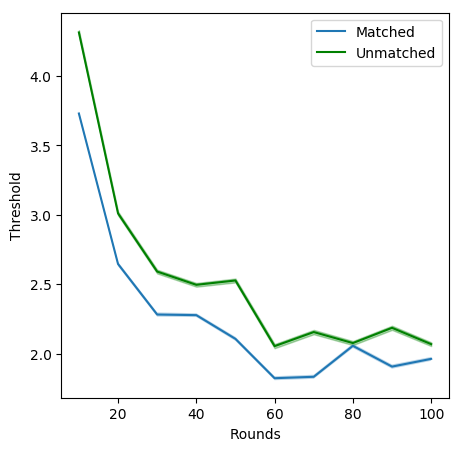

In [13]:
match = get_params("a", actions.loc[actions["type"] == actions["type_adj"], "user"].values)
unmatch = get_params("a", actions.loc[actions["type"] != actions["type_adj"], "user"].values)
errMatch = match["std"] / np.sqrt(5000)
errUnmatch = unmatch["std"] / np.sqrt(5000)

plt.style.use("default")
plt.figure(figsize=(5,5))
plt.plot(match["round"], match.a,label = "Matched")
plt.fill_between(match["round"], match.a + (errMatch * 1.96), match.a - (errMatch * 1.96), alpha = 0.3)
plt.plot(unmatch["round"], unmatch.a,label = "Unmatched", color = "green")
plt.fill_between(unmatch["round"], unmatch.a + (errUnmatch * 1.96), unmatch.a - (errUnmatch * 1.96), alpha = 0.3, color = "green")
#plt.errorbar(unmatch["round"], unmatch.a, yerr = unmatch["std"] ,label = "Unmatched", color = "green")
plt.xlabel("Rounds")
plt.ylabel("Threshold")
plt.legend()

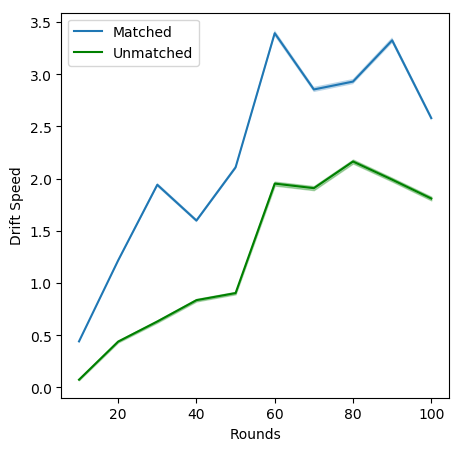

In [14]:
match = get_params("v", actions.loc[actions["type"] == actions["type_adj"], "user"].values)
unmatch = get_params("v", actions.loc[actions["type"] != actions["type_adj"], "user"].values)
errMatch = match["std"] / np.sqrt(5000)
errUnmatch = unmatch["std"] / np.sqrt(5000)

plt.style.use("default")
plt.figure(figsize=(5,5))
plt.plot(match["round"], match.v,label = "Matched")
plt.fill_between(match["round"], match.v + (errMatch * 1.96), match.v - (errMatch * 1.96), alpha = 0.3)
plt.plot(unmatch["round"], unmatch.v,label = "Unmatched", color = "green")
plt.fill_between(unmatch["round"], unmatch.v + (errUnmatch * 1.96), unmatch.v - (errUnmatch * 1.96), alpha = 0.3, color = "green")
#plt.errorbar(unmatch["round"], unmatch.a, yerr = unmatch["std"] ,label = "Unmatched", color = "green")
plt.xlabel("Rounds")
plt.ylabel("Drift Speed")
plt.legend()

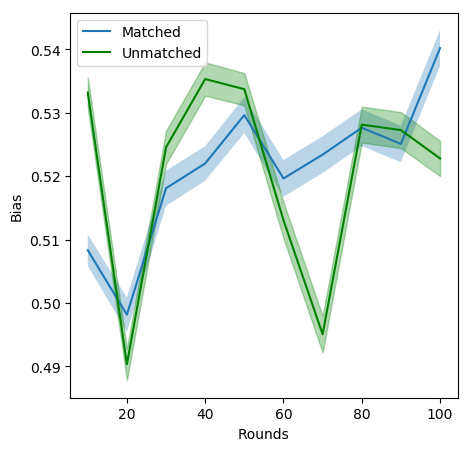

In [15]:
match = get_params("z", actions.loc[actions["type"] == actions["type_adj"], "user"].values)
unmatch = get_params("z", actions.loc[actions["type"] != actions["type_adj"], "user"].values)
errMatch = match["std"] / np.sqrt(5000)
errUnmatch = unmatch["std"] / np.sqrt(5000)

plt.style.use("default")
plt.figure(figsize=(5,5))
plt.plot(match["round"], match.z,label = "Matched")
plt.fill_between(match["round"], match.z+ (errMatch * 1.96), match.z- (errMatch * 1.96), alpha = 0.3)
plt.plot(unmatch["round"], unmatch.z,label = "Unmatched", color = "green")
plt.fill_between(unmatch["round"], unmatch.z+ (errUnmatch * 1.96), unmatch.z- (errUnmatch * 1.96), alpha = 0.3, color = "green")
#plt.errorbar(unmatch["round"], unmatch.a, yerr = unmatch["std"] ,label = "Unmatched", color = "green")
plt.xlabel("Rounds")
plt.ylabel("Bias")
plt.legend()

In [1]:
import numpy.matlib
curve = params_weak.mean()[["a10","a20","a30","a40","a50","a60","a70","a80","a90","a100"]]
nPoints = len(curve)
allCoord = np.vstack((range(nPoints), curve)).T
np.array([range(nPoints), curve])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)
idxOfBestPoint

NameError: name 'params_weak' is not defined

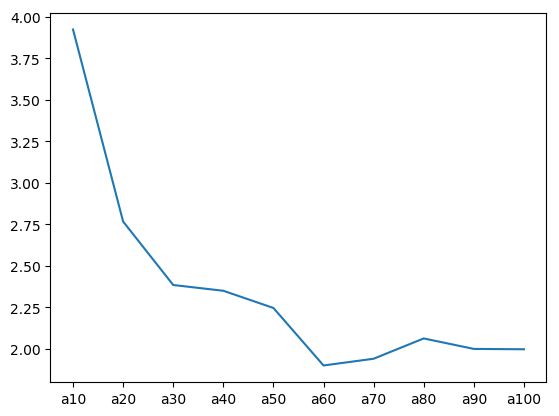

In [17]:
plt.plot(params_weak.mean()[["a10","a20","a30","a40","a50","a60","a70","a80","a90","a100"]])

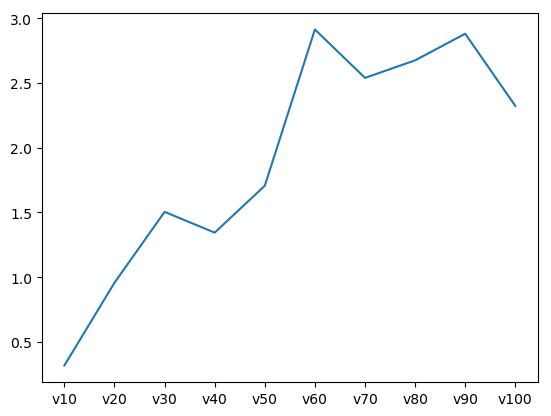

In [29]:
plt.plot(params_weak.mean()[["v10","v20","v30","v40","v50","v60","v70","v80","v90","v100"]])